# A Study of Potential Influencing Factors on Canadian Immigrants.
### CSCI 6405 -- Data Mining Project, Dalhousie University.
### By Hongwei Zhang, January - April 2023.

## Experiment 1: Study the reasons for Canadian immigrants leaving their home countries based on economic and social indicators for their countries.
### Data mining methods: Kmeans Clustering, Hierarchical Clustering
### Datasets used: The number of immigrants in Canada by country in the past ten years (2011-2021), and the economic and social indicators of the corresponding countries.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_samples, silhouette_score

In [68]:
# Organizing and processing Canadian immigration dataset.
im = pd.read_csv("Datasets/immigrants.csv", skiprows=14, nrows=215)
im.columns=['Birthplace', '1980-1990', '1991-2000', '2001-2010', '2011-2021']

for i in range(len(im)):
    if im['Birthplace'][i][-2:].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-3]
    if im['Birthplace'][i][-1].isdigit():
        im['Birthplace'][i] = im['Birthplace'][i][0:-2]

    im['1980-1990'][i] = int(im['1980-1990'][i].replace(',', ''))
    im['1991-2000'][i] = int(im['1991-2000'][i].replace(',', ''))
    im['2001-2010'][i] = int(im['2001-2010'][i].replace(',', ''))
    im['2011-2021'][i] = int(im['2011-2021'][i].replace(',', ''))
    if im['1980-1990'][i] == 0 and im['1991-2000'][i] == 0 and im['2001-2010'][i] == 0 and im['2011-2021'][i] == 0:
        im=im.drop(labels=i)

im = im.sort_values(by=['Birthplace'])
im.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(im))
im.head()

Number of country/region: 200


,Birthplace,1980-1990,1991-2000,2001-2010,2011-2021
0,Afghanistan,3920,14745,22280,21340
1,Albania,15,4130,8000,5500
2,Algeria,1345,11745,32430,32580
3,Andorra,0,0,0,30
4,Angola,415,390,1315,580


In [69]:
# Filtering data from each dataset for 2011.
'''
Dataset name and meaning:
gdp: GDP per capita (current US$), GDP11 = GDP per capita for 2011.
life: Life expectancy at birth, total (years), LE11.
inflation: Inflation, consumer prices (annual %), IF11.
employment: Employment to population ratio, 15+, total (%), EM11.
female: Labor force participation rate, female (% of female population ages 15+), FM11.
health: Current health expenditure (% of GDP), HE11.
education: Government expenditure on education, total (% of GDP), ED11.
'''

gdp = pd.read_csv("Datasets/gdp.csv", skiprows=4, nrows=266, usecols=[0, 55])
gdp.columns = ['Birthplace', 'GDP11']
life = pd.read_csv("Datasets/life.csv", skiprows=4, usecols=[55])
life.columns = ['LE11']
inflation = pd.read_csv("Datasets/inflation.csv", skiprows=4, usecols=[55])
inflation.columns = ['IF11']
employment = pd.read_csv("Datasets/employment.csv", skiprows=4, usecols=[55])
employment.columns = ['EM11']
female = pd.read_csv("Datasets/female.csv", skiprows=4, usecols=[55])
female.columns = ['FM11']
health = pd.read_csv("Datasets/health.csv", skiprows=4, usecols=[55])
health.columns = ['HE11']
education = pd.read_csv("Datasets/education.csv", skiprows=4, usecols=[55])
education.columns = ['ED11']

comb = pd.concat([gdp, life, inflation, employment, female, health, education], axis=1)
print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 266


,Birthplace,GDP11,LE11,IF11,EM11,FM11,HE11,ED11
0,Aruba,26044.435933,75.465000,4.316297,NaN,NaN,NaN,6.11913
1,Africa Eastern and Southern,1792.847428,59.293271,8.971206,65.610090,64.596561,6.774233,4.38598
2,Afghanistan,621.912311,61.419000,11.804186,43.180000,15.784000,8.561907,3.46201
3,Africa Western and Central,1856.687669,55.013138,4.018699,61.222896,57.979904,3.547476,2.66890
4,Angola,4511.153227,57.596000,13.482468,71.628998,74.873001,2.645608,3.03000


In [70]:
# Delete missing values
comb.dropna(axis=0,subset = ['GDP11', 'LE11', 'IF11', 'EM11', 'FM11', 'HE11', 'ED11'], inplace=True)
comb = comb.sort_values(by=['Birthplace'])
comb.reset_index(drop=True, inplace=True)

print("Number of country/region:", len(comb))
comb.head()

Number of country/region: 191


,Birthplace,GDP11,LE11,IF11,EM11,FM11,HE11,ED11
0,Afghanistan,621.912311,61.419000,11.804186,43.180000,15.784000,8.561907,3.46201
1,Africa Eastern and Southern,1792.847428,59.293271,8.971206,65.610090,64.596561,6.774233,4.38598
2,Africa Western and Central,1856.687669,55.013138,4.018699,61.222896,57.979904,3.547476,2.66890
3,Albania,4437.142612,78.092000,3.429123,51.860001,52.467999,4.795341,3.08000
4,Angola,4511.153227,57.596000,13.482468,71.628998,74.873001,2.645608,3.03000


In [71]:
# Generate the dataset to be used.
a0, a1, a2, a3, a4, a5, a6, a7, a8 = [], [], [], [], [], [], [], [], []
for m in range(len(comb)):
    for n in range(len(im)):
        if comb['Birthplace'][m] == im['Birthplace'][n]:
            a0.append(im['Birthplace'][n])
            a1.append(im['2011-2021'][n])
            a2.append(comb['GDP11'][m])
            a3.append(comb['LE11'][m])
            a4.append(comb['IF11'][m])
            a5.append(comb['EM11'][m])
            a6.append(comb['FM11'][m])
            a7.append(comb['HE11'][m])
            a8.append(comb['ED11'][m])

dataset = pd.DataFrame({'Birthplace':a0, 'Immigration':a1, 'GDP':a2,
                        'LE':a3, 'IF':a4, 'EM':a5,
                        'FM':a6, 'HE':a7, 'ED':a8})
print("Number of country/region:", len(dataset))
dataset.head()

Number of country/region: 123


,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,21340,621.912311,61.419000,11.804186,43.180000,15.784000,8.561907,3.46201
1,Albania,5500,4437.142612,78.092000,3.429123,51.860001,52.467999,4.795341,3.08000
2,Angola,580,4511.153227,57.596000,13.482468,71.628998,74.873001,2.645608,3.03000
3,Armenia,2120,3462.681611,73.305000,7.650008,54.722000,55.479000,9.375878,3.14385
4,Austria,785,51442.276246,80.982927,3.286579,57.731998,54.507000,10.026133,5.59227


In [72]:
dataset.describe()

,Immigration,GDP,LE,IF,EM,FM,HE,ED
count,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000,123.000000
mean,14623.089431,15862.184147,70.535927,6.293226,57.733618,51.848447,6.201244,4.331010
std,50682.558227,22789.956387,9.140463,6.173362,10.989294,13.532865,2.591974,1.751489
min,10.000000,236.451354,46.692000,-0.400041,33.969002,14.506000,1.599962,0.582609
25%,855.000000,1473.764228,63.697500,3.263304,51.041500,44.900999,4.098660,3.069495
50%,2850.000000,5614.352135,73.266829,4.971486,57.286999,52.598000,5.859718,4.242090
75%,7100.000000,19890.792615,78.264000,8.024278,65.173000,58.725000,8.190179,5.484372
max,390965.000000,119025.057203,82.695122,53.228698,86.007004,83.807999,13.281343,10.194730


<Axes: >

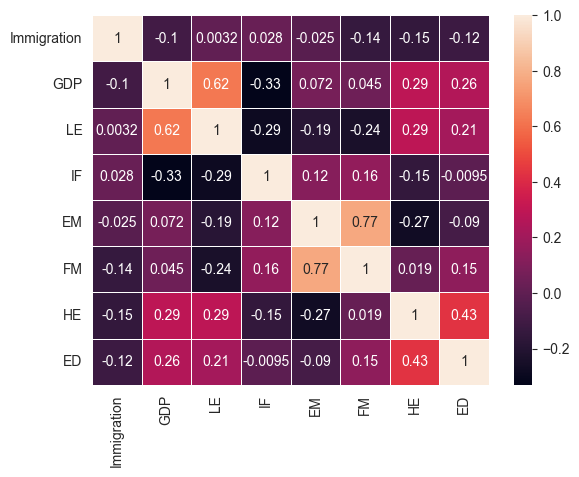

In [73]:
# Generate correlation coefficient heat map.
corr = dataset.corr(numeric_only=True)
sb.heatmap(corr, annot=True, linewidth=0.5)

[Text(0.5, 0, 'Government expenditure on education'),
 Text(0, 0.5, 'Country or Region')]

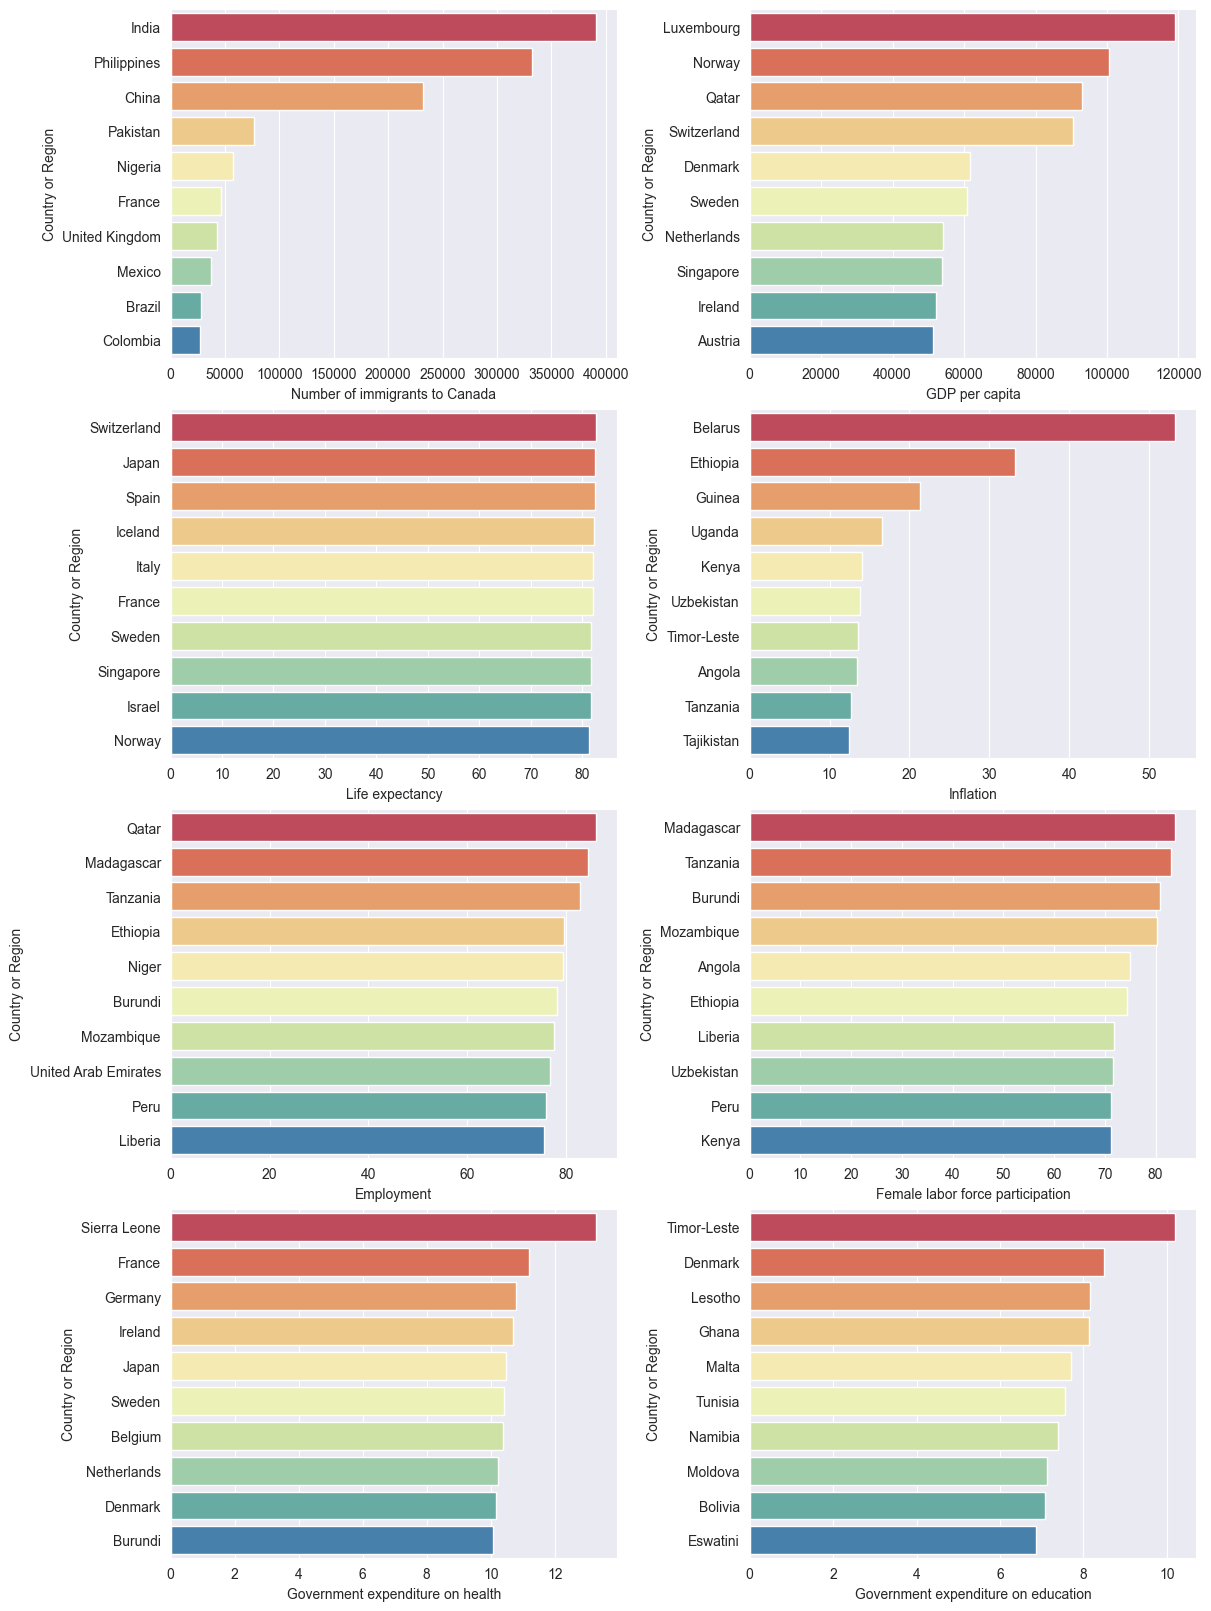

In [74]:
# Display bar graphs for relevant data.
fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(12,16))

sb.barplot(x='Immigration', y='Birthplace', data=dataset.nlargest(10, 'Immigration'), ax=axes[0,0], palette="Spectral")\
    .set(xlabel='Number of immigrants to Canada', ylabel='Country or Region')

sb.barplot(x='GDP' ,y='Birthplace', data=dataset.nlargest(10, 'GDP'), ax=axes[0,1], palette="Spectral")\
    .set(xlabel='GDP per capita', ylabel='Country or Region')

sb.barplot(x='LE',y='Birthplace', data=dataset.nlargest(10, 'LE'), ax=axes[1,0], palette="Spectral")\
    .set(xlabel='Life expectancy', ylabel='Country or Region')

sb.barplot(x='IF' ,y='Birthplace', data=dataset.nlargest(10, 'IF'), ax=axes[1,1], palette="Spectral")\
    .set(xlabel='Inflation', ylabel='Country or Region')

sb.barplot(x='EM',y='Birthplace', data=dataset.nlargest(10, 'EM'), ax=axes[2,0], palette="Spectral")\
    .set(xlabel='Employment', ylabel='Country or Region')

sb.barplot(x='FM',y='Birthplace', data=dataset.nlargest(10, 'FM'), ax=axes[2,1], palette="Spectral")\
    .set(xlabel='Female labor force participation', ylabel='Country or Region')

sb.barplot(x='HE' ,y='Birthplace', data=dataset.nlargest(10, 'HE'), ax=axes[3,0], palette="Spectral")\
    .set(xlabel='Government expenditure on health', ylabel='Country or Region')

sb.barplot(x='ED',y='Birthplace', data=dataset.nlargest(10, 'ED'), ax=axes[3,1], palette="Spectral")\
    .set(xlabel='Government expenditure on education', ylabel='Country or Region')

In [75]:
# Normalize so that the data falls between 0 and 1.

nor = normalize([dataset['Immigration']])
dataset['Immigration'] = nor[0][:]

nor = normalize([dataset['GDP']])
dataset['GDP'] = nor[0][:]

nor = normalize([dataset['LE']])
dataset['LE'] = nor[0][:]

nor = normalize([dataset['IF']])
dataset['IF'] = nor[0][:]

nor = normalize([dataset['EM']])
dataset['EM'] = nor[0][:]

nor = normalize([dataset['FM']])
dataset['FM'] = nor[0][:]

nor = normalize([dataset['HE']])
dataset['HE'] = nor[0][:]

nor = normalize([dataset['ED']])
dataset['ED'] = nor[0][:]

dataset.head()

,Birthplace,Immigration,GDP,LE,IF,EM,FM,HE,ED
0,Afghanistan,0.036615,0.002025,0.077867,0.120976,0.066257,0.026566,0.114931,0.066856
1,Albania,0.009437,0.014448,0.099005,0.035144,0.079576,0.088310,0.064370,0.059479
2,Angola,0.000995,0.014689,0.073020,0.138176,0.109911,0.126020,0.035513,0.058514
3,Armenia,0.003637,0.011275,0.092936,0.078401,0.083968,0.093377,0.125857,0.060712
4,Austria,0.001347,0.167508,0.102670,0.033683,0.088587,0.091741,0.134586,0.107995


2 clusters, the silhouette score is 0.8535125840814485
3 clusters, the silhouette score is 0.7234703951782296
4 clusters, the silhouette score is 0.7191173936030644
5 clusters, the silhouette score is 0.5733817118080207
6 clusters, the silhouette score is 0.556547176986614


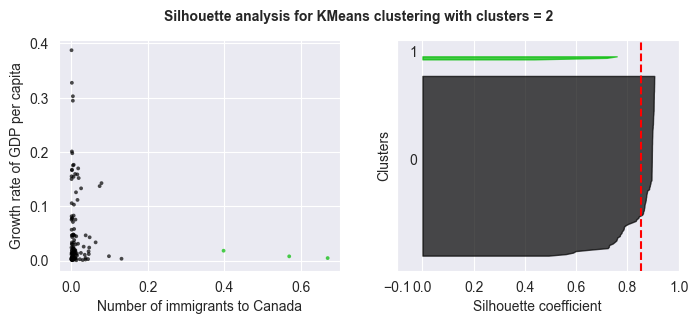

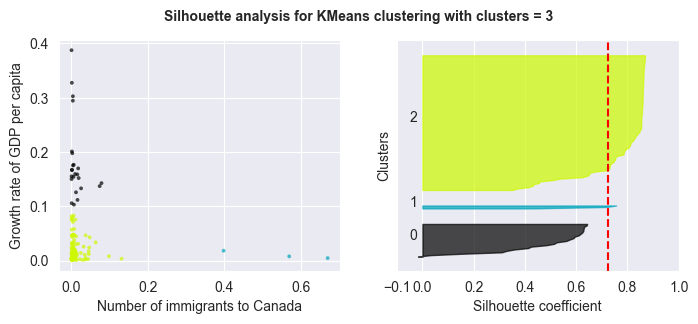

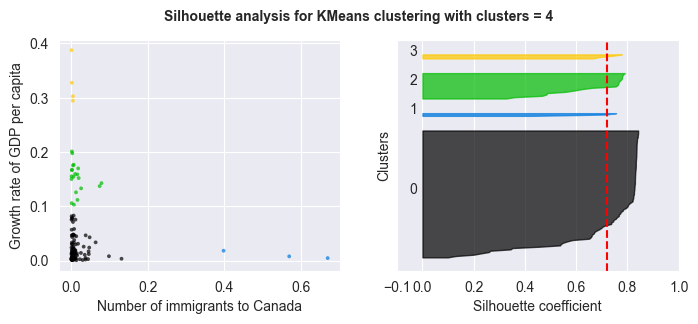

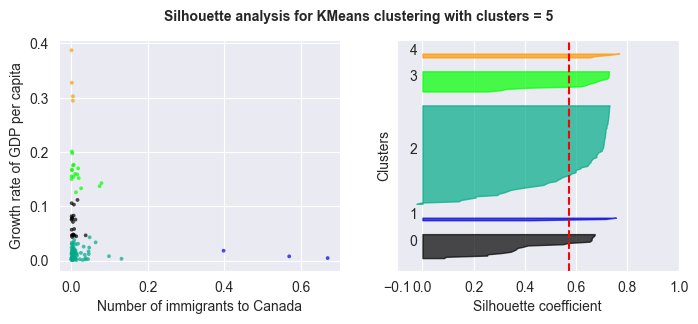

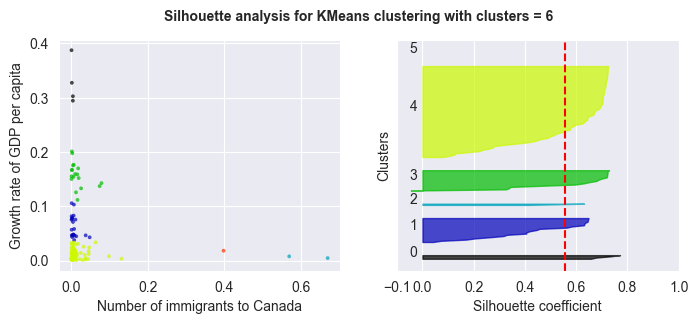

In [76]:
'''
Perform Kmeans clustering on the dataset, calculate the silhouette coefficients, and draw the silhouette plots.
The code used to draw the silhouette plots is from scikit-learn:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

The results and silhouette plots from 2 clusters to 6 clusters are shown separately.
In order to find the most suitable number of clusters for clustering.
'''

for i in range(2, 7):
    X1 = pd.DataFrame({'Immigration':dataset['Immigration'], 'GDP':dataset['GDP']}).to_numpy()
    c1 = KMeans(n_clusters=i, random_state=0, n_init=10)
    label1 = c1.fit_predict(X1)
    silhouette = silhouette_score(X1, label1)
    print(i, 'clusters, the silhouette score is', silhouette)

    sample_silhouette = silhouette_samples(X1, label1)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 3)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([0, len(X1) + (i + 1) * 10])
    y_lower = 10

    for n in range(i):
        cluster_silhouette_values = sample_silhouette[label1 == n]
        cluster_silhouette_values.sort()
        cluster_size = cluster_silhouette_values.shape[0]
        y_upper = y_lower + cluster_size
        color = cm.nipy_spectral(n / i)
        ax2.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax2.text(-0.05, y_lower + 0.5 * cluster_size, str(n))
        y_lower = y_upper + 10

    ax2.set_xlabel("Silhouette coefficient")
    ax2.set_ylabel("Clusters")
    ax2.axvline(x=silhouette, color="red", linestyle="--")
    ax2.set_yticks([])
    ax2.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(label1.astype(float) / i)
    ax1.scatter(X1[:, 0], X1[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    ax1.set_xlabel("Number of immigrants to Canada")
    ax1.set_ylabel("Growth rate of GDP per capita")
    plt.suptitle("Silhouette analysis for KMeans clustering with clusters = %d" % i, fontsize=10, fontweight="bold",)

plt.show()

In [77]:
# By comparing the silhouette coefficients to find the most suitable number of clusters.
def choose_cluster(table):
    score = 0
    n = 0

    for i in range(2, 10):
        c = KMeans(n_clusters=i, random_state=0, n_init=10)
        label = c.fit_predict(table)
        sil = silhouette_score(table, label)

        if sil > score:
            score = sil
            n = i

    print(n, 'clusters, the silhouette score is', score)
    return n

# Perform Kmeans clustering and output the clustering results for each cluster (by country).
def plot_cluster(table, n, x_label):
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    cx = KMeans(n_clusters=n, random_state=0, n_init=10).fit_predict(table)
    plt.figure(figsize=(4,3))

    for j in range(n):
        plt.scatter(table[cx==j, 0], table[cx==j, 1], s=10, c=color[j], label ='Cluster %d'% (j + 1))
        group = []

        for k in range(len(a0)):
            if cx[k] == j:
                group.append(a0[k])

        print('Cluster %d:'% (j + 1), group)
        group.clear()

    plt.xlabel(x_label)
    plt.ylabel('Immigrants')
    plt.legend()
    plt.show()

2 clusters, the silhouette score is 0.8535125840814485
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

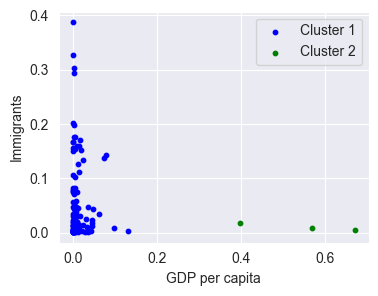

In [78]:
# Clustering using the change in GDP per capita from 2011 to 2021 with the number of immigrants to Canada in this decade.
X1 = pd.DataFrame({'Immigration':dataset['Immigration'], 'GDP':dataset['GDP']}).to_numpy()
plot_cluster(X1, choose_cluster(X1), 'GDP per capita')

2 clusters, the silhouette score is 0.9449396732906807
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

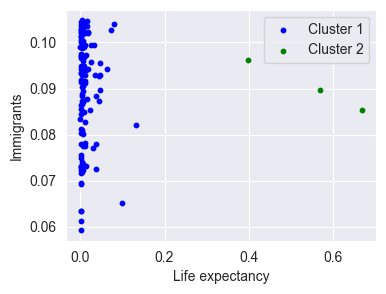

In [79]:
# Clustering using the change in life expectancy from 2011 to 2021 with the number of immigrants to Canada in this decade.
X2 = pd.DataFrame({'Immigration':dataset['Immigration'], 'LE':dataset['LE']}).to_numpy()
plot_cluster(X2, choose_cluster(X2), 'Life expectancy')

2 clusters, the silhouette score is 0.8826308369209057
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

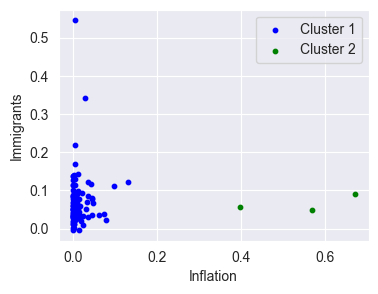

In [80]:
X3 = pd.DataFrame({'Immigration':dataset['Immigration'], 'IF':dataset['IF']}).to_numpy()
plot_cluster(X3, choose_cluster(X3), 'Inflation')

2 clusters, the silhouette score is 0.9358428773459663
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

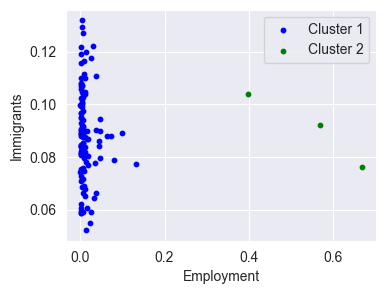

In [81]:
X4 = pd.DataFrame({'Immigration':dataset['Immigration'], 'EM':dataset['EM']}).to_numpy()
plot_cluster(X4, choose_cluster(X4), 'Employment')

2 clusters, the silhouette score is 0.9271642911917479
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

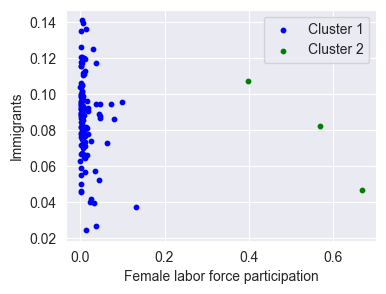

In [82]:
X5 = pd.DataFrame({'Immigration':dataset['Immigration'], 'FM':dataset['FM']}).to_numpy()
plot_cluster(X5, choose_cluster(X5), 'Female labor force participation')

2 clusters, the silhouette score is 0.9031085687423323
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

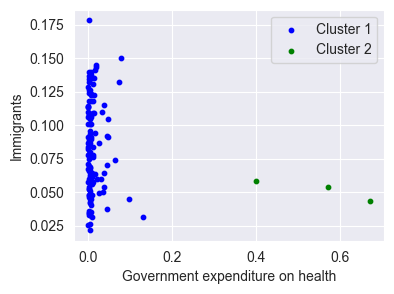

In [83]:
X6 = pd.DataFrame({'Immigration':dataset['Immigration'], 'HE':dataset['HE']}).to_numpy()
plot_cluster(X6, choose_cluster(X6), 'Government expenditure on health')

2 clusters, the silhouette score is 0.9060439012653217
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

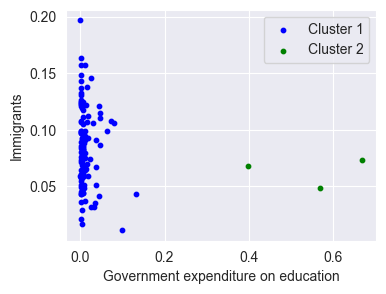

In [84]:
X7 = pd.DataFrame({'Immigration':dataset['Immigration'], 'ED':dataset['ED']}).to_numpy()
plot_cluster(X7, choose_cluster(X7), 'Government expenditure on education')

2 clusters, the silhouette score is 0.7449803536051736
Cluster 1: ['Afghanistan', 'Albania', 'Angola', 'Armenia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'Colombia', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Honduras', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kuwait', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta', 'Mauritania', 'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Mozambique'

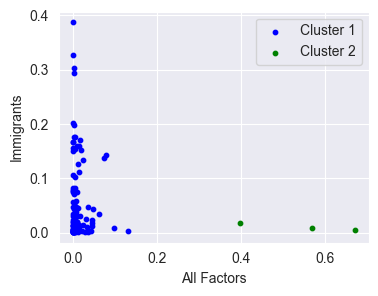

In [85]:
# Clustering with all other indicators using immigrants data.
X8 = dataset.drop(['Birthplace'], axis=1).to_numpy()
plot_cluster(X8, choose_cluster(X8), 'All Factors')

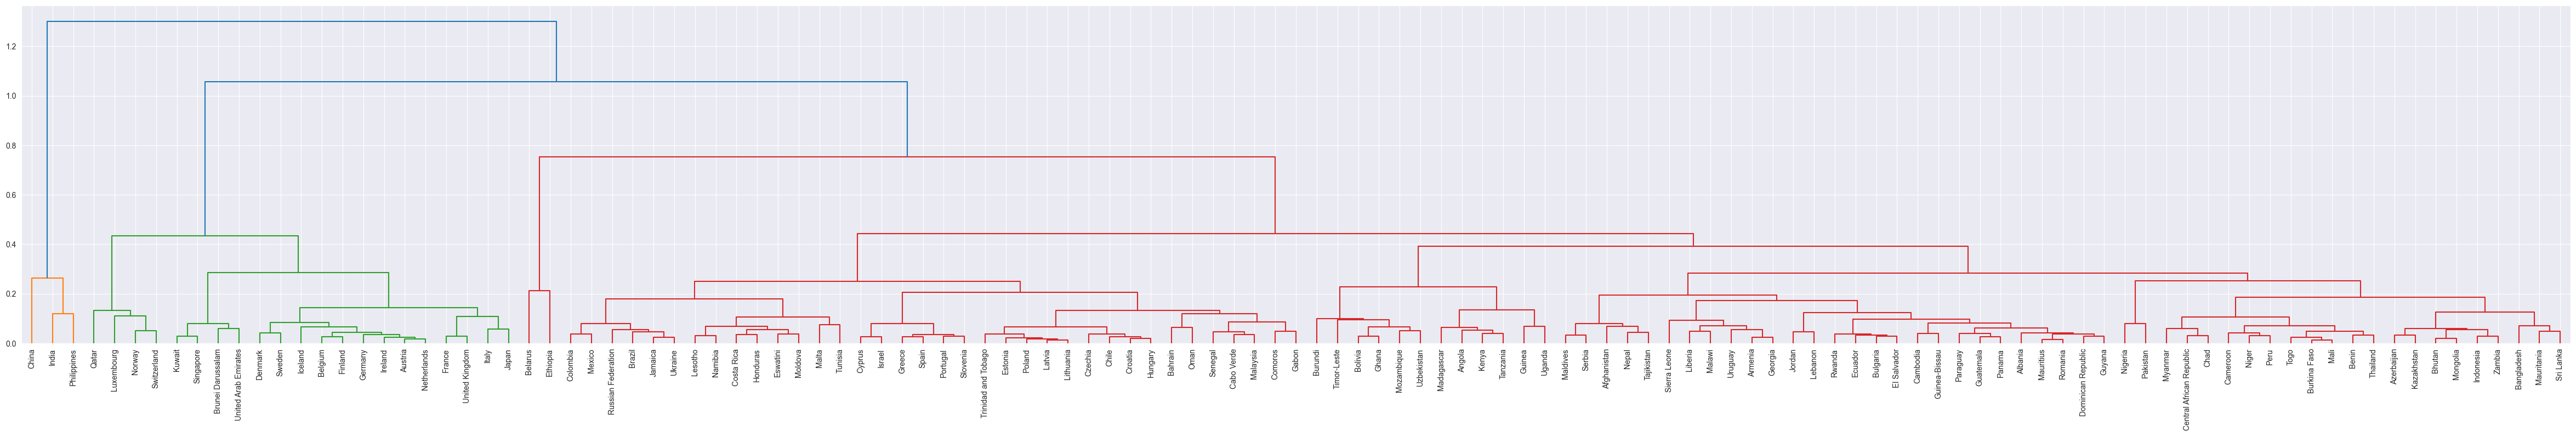

In [86]:
# Hierarchical clustering using the entire dataset.
comb_data = dataset.drop(['Birthplace'], axis=1)
plt.figure(figsize=(60, 8))
dend=sch.dendrogram(sch.linkage(comb_data,method='ward'), labels=a0, leaf_font_size=10)

### End of Experiments.